# Compare PDU and Sorbitol
* * *

In [19]:
library(ggtree)
library("dendextend")
library("phangorn")

## functions

In [46]:
makeDendros <- function(firstTree, secondTree)
{
  firstTree <- midpoint(firstTree)
  secondTree <- midpoint(secondTree)
#  firstTree <- midpoint.root(firstTree)
#  secondTree <- midpoint.root(secondTree)
  firstTree$edge.length[which(firstTree$edge.length == 0)] <- 1e-20
  firstTree <- chronopl(firstTree, lambda = 0.01, tol = 1e-19, iter.max = 2000, eval.max = 2000)
  firstTree <- as.dendrogram(firstTree)
  secondTree$edge.length[which(secondTree$edge.length == 0)] <- 1e-20
  secondTree <- chronopl(secondTree, lambda = 0.01, tol = 1e-19, iter.max = 2000, eval.max = 2000)
  secondTree <- as.dendrogram(secondTree)
  dends <- dendlist(firstTree, secondTree)
  dends <- dends %>% untangle(method = "step2side")
  return(dends)
}

plot_tree_compare <- function(dends, title)
{
  dends %>% plot(main = title, common_subtrees_color_branches = TRUE)
}

## calc pdu and hemin dendrograms

In [3]:
pdu_region_tree <- read.tree("studio/pdu/pdu.fasta.raxml.bestTree")
pdu_core_tree <- read.tree("studio/pdu/core_pdu_aligned.fasta.raxml.bestTree")
sorbitol_region_tree <- read.tree("studio/sorbitol/sorbitol_aligned.fasta.raxml.bestTree")
sorbitol_core_tree <- read.tree("studio/sorbitol/coreogaligned.fasta.raxml.bestTree")

In [43]:
dends_pdu = makeDendros(pdu_core_tree, pdu_region_tree)

In [44]:
dends_srb = makeDendros(sorbitol_core_tree, sorbitol_region_tree)

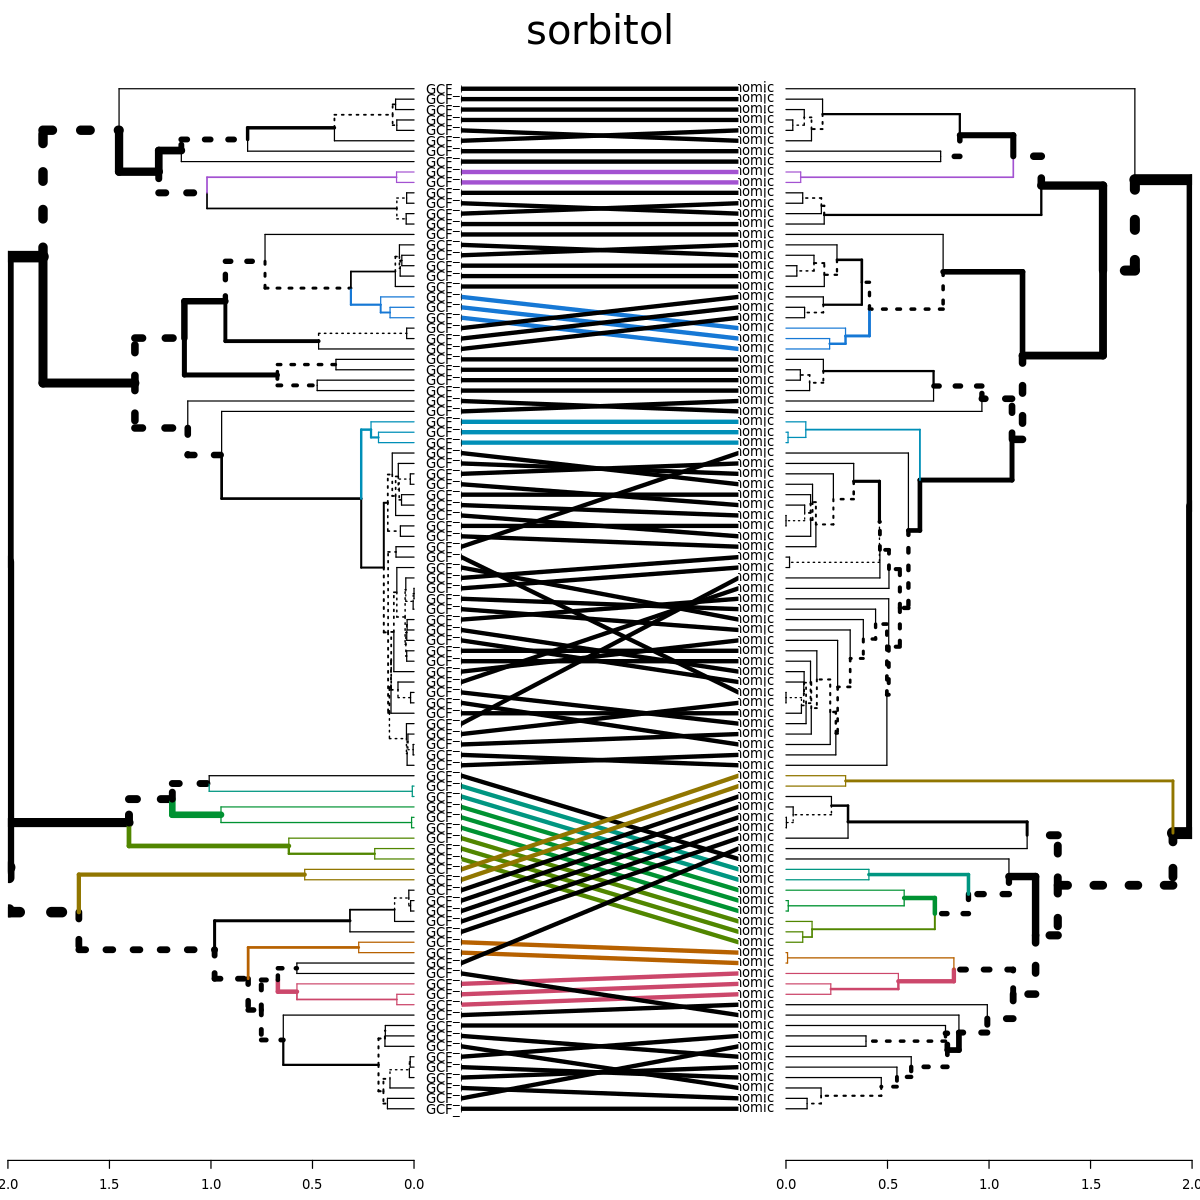

In [47]:
options(repr.plot.width=10, repr.plot.height=10)
plot_tree_compare(dends_srb, "sorbitol")

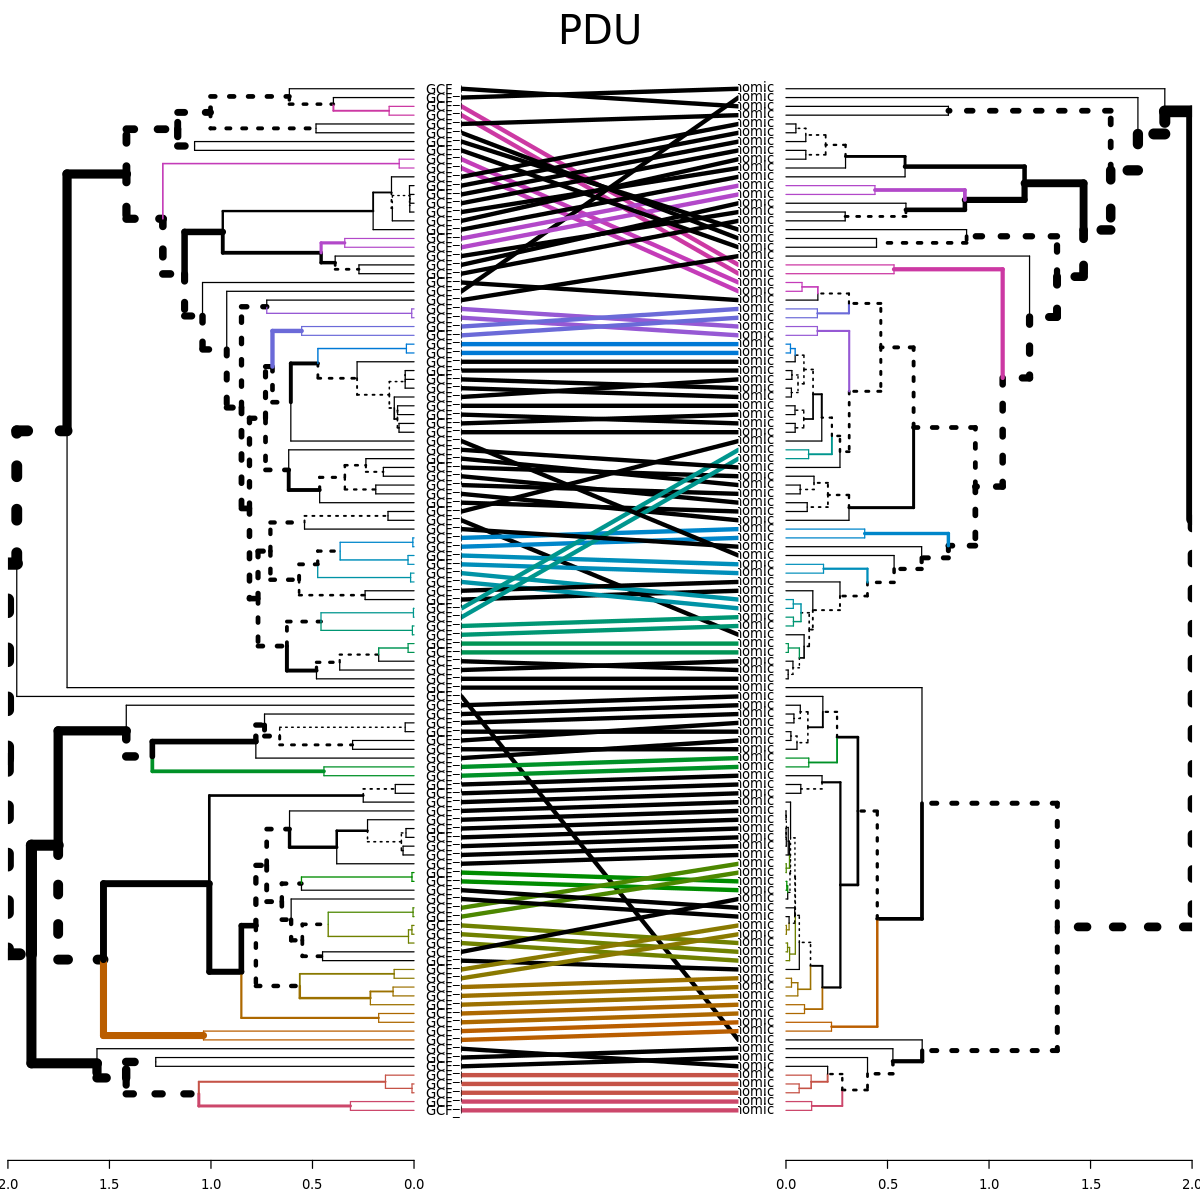

In [48]:
plot_tree_compare(dends_pdu, "PDU")

# RF distance gives sighificant difference

In [21]:
calc_rf_histo = function(region_tree,core_tree, REPEATS, TAXA_SUBSET)
{
    taxas <- region_tree$tip.label
    N <- REPEATS
    rf_values <- rep(NA, N)
    for(i in 1:N)
    {
      res = try({
        the_taxas <- sample(taxas, TAXA_SUBSET)
        to_del_taxas <- setdiff(taxas, the_taxas)
        region_subtree <- drop.tip(region_tree, to_del_taxas)
        core_subtree <- drop.tip(core_tree, to_del_taxas)
        rf_values[i] = wRF.dist(region_subtree, core_subtree)
      })
      if(isTRUE(class(res)=="try-error")) { next } 
    }    
    return(rf_values)
}


In [ ]:
rf_srb = calc_rf_histo(sorbitol_region_tree, sorbitol_core_tree, 100, 30) >> logs/log_r
rf_pdu = calc_rf_histo(pdu_region_tree, pdu_core_tree, 100, 30) >> logs/log_r

In [25]:
wilcox.test(rf_pdu, rf_srb)


	Wilcoxon rank sum test with continuity correction

data:  rf_pdu and rf_srb
W = 9905, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


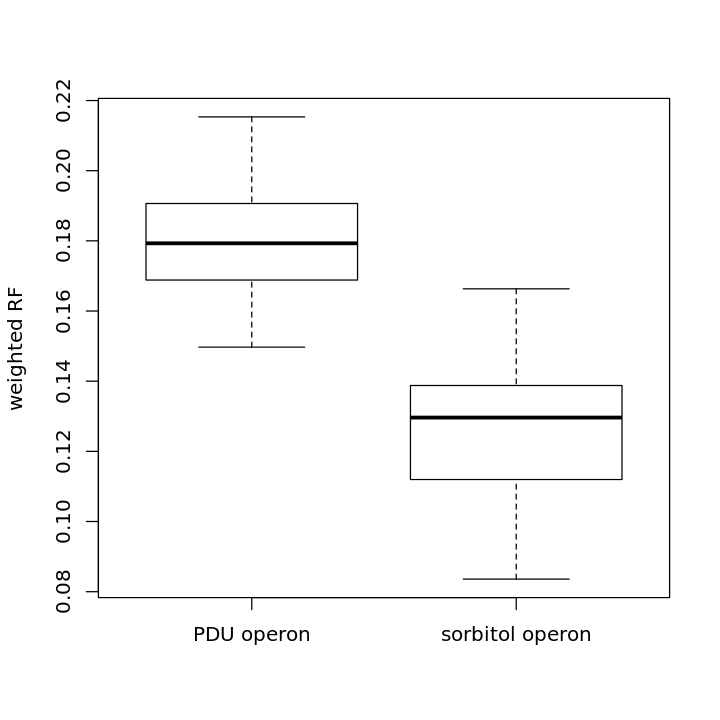

In [30]:
options(repr.plot.width=6, repr.plot.height=6)
boxplot(rf_pdu, rf_srb, names = c("PDU operon","sorbitol operon"), ylab = "weighted RF")